In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from gensim.models import Word2Vec as wv

%load_ext autoreload
%matplotlib inline

module_path = os.path.abspath(os.path.join('./syn_ant_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import model_dataset as dataset 
import model_functions_PhaseI as functions
import model_morphology as morpho
import model_testing_PhaseI as test 
import model_training_PhaseI as train

torch.manual_seed(28)

In [2]:
word_pairs_df = pd.read_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')
word_pairs_df

,Unnamed: 0,word 1,word 2,label
0,0,infinite,bounded,2
1,1,infinite,brief,2
2,2,infinite,calculable,0
3,3,infinite,ceasing,2
4,4,infinite,ending,2
...,...,...,...,...
14227,14227,charm,fascinate,1
14228,14228,charm,magical spell,1
14229,14229,charm,appealingness,1
14230,14230,charm,enchant,1


In [3]:
word_pairs_df['label'].value_counts()

1    6534
0    4696
2    3002
Name: label, dtype: int64

In [4]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

w2v_model_path = '/Users/wesleytatum/Desktop/post_doc/data/w2v_models/200D_all_abstracts_model/full_corpus_w2v_mc5_s200_wdw10.model'
model1 = wv.load(w2v_model_path)
vocabulary1 = list(model1.wv.vocab)
print(f'w2v vocab length: {len(vocabulary1)}')

w2v_data_df = word_pairs_df.copy()

#finding which words are in the pd but not in vocabulary1
list1 = list(word_pairs_df['word 1'])
list2 = list(word_pairs_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))
print(f'number of word pair words: {len(list(set(list1+list2)))}')
print(f'number of missing words: {len(missing)}')

#keeping only the rows in the pd that have words in vocabulary1
w2v_data_df = w2v_data_df[~w2v_data_df['word 1'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['word 2'].isin(missing)]

#reseting indeces after mask
w2v_data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)
print(f'length of common vocab: {len(common)}')


w2v vocab length: 358151
number of word pair words: 9043
number of missing words: 2322
length of common vocab: 6733


In [5]:
#save vocab list and call it in the Pre_Trained_Embeddings
common_df = pd.DataFrame(common)
common_df.to_csv('./data/words_list.csv', index=False)


In [6]:
#for word pairs in our proposed training set, check if both words are in
#the common vocabulary list and then create a new dataframe with their indices

w2v_indx_df = pd.DataFrame(columns = ['word 1', 'word 2', 'label'])

pbar = tqdm(total = len(w2v_data_df), position = 0)

for i in range(len(w2v_data_df)):
    
    word1 = w2v_data_df['word 1'].iloc[i]
    word2 = w2v_data_df['word 2'].iloc[i]
    label = w2v_data_df['label'].iloc[i]
    
    if word1 in common:
        if word2 in common:
            index1 = common.index(word1)
            index2 = common.index(word2)
            w2v_indx_df.loc[i] = pd.Series({'word 1':index1, 'word 2':index2, 'label':label})
        else:
            pass
    else:
        pass
    pbar.update()

w2v_indx_df.label.value_counts()
w2v_indx_df

100%|█████████▉| 10886/10916 [00:29<00:00, 384.51it/s]

,word 1,word 2,label
0,3140,663,2
1,3140,696,2
2,3140,763,0
3,3140,842,2
4,3140,2071,2
...,...,...,...
10911,3701,356,1
10912,3701,3700,1
10913,3701,3258,1
10914,891,2362,1


In [7]:
X = w2v_indx_df[['word 1', 'word 2']]
Y = w2v_indx_df['label']

xtr, xts, ytr, yts = train_test_split(X, Y, test_size = 0.2, shuffle = True)

xtr_tens = torch.from_numpy(xtr.values.astype(float))
xts_tens = torch.from_numpy(xts.values.astype(float))
ytr_tens = torch.tensor(ytr.values.astype(float))
yts_tens = torch.tensor(yts.values.astype(float))

xtr_tens = xtr_tens.type(torch.long)
xts_tens = xts_tens.type(torch.long)
ytr_tens = ytr_tens.type(torch.long)
yts_tens = yts_tens.type(torch.long)

train_set = TensorDataset(xtr_tens, ytr_tens)
test_set = TensorDataset(xts_tens, yts_tens)

In [8]:
print(torch.unique(yts_tens))

tensor([0, 1, 2])


In [9]:
#Hyper parameters
num_epochs = 30
batch_size = 50
learning_rate = 5e-4

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle = True)

100%|██████████| 10916/10916 [00:40<00:00, 384.51it/s]

In [10]:
%autoreload

vocab_length = len(common)+1 #+1 avoids indexing error
print(f'vocabulary length = {vocab_length}')

# Instantiate NN model. 'in_dims' = dimensions of embeddings in 'common'
model = morpho.Phase_I_NN(in_dims = 200,
                          vocab_length = vocab_length,
                          common = common,
                          w2v_model = model1).to(device)
model.apply(functions.init_weights)

#define the optimizer
optimizer = torch.optim.AdamW(params = model.parameters(),
                              lr = learning_rate,
                              amsgrad = True)

vocabulary length = 6734


In [11]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
syn_train_epoch_losses = []
ant_train_epoch_losses = []
syn_train_epoch_accuracies = []
ant_train_epoch_accuracies = []
irrel_train_epoch_accuracies = []
train_p2_syn_accs = []
train_p2_ant_accs = []
train_p2_irrel_accs = []

test_epoch_losses = []
syn_test_epoch_losses = []
ant_test_epoch_losses = []
syn_test_epoch_accuracies = []
ant_test_epoch_accuracies = []
irrel_test_epoch_accuracies = []
test_p2_syn_accs = []
test_p2_ant_accs = []
test_p2_irrel_accs = []

pbar = tqdm(total = num_epochs, position = 0)

for epoch in range(num_epochs):
    
    train_epoch_loss, syn_train_epoch_loss, ant_train_epoch_loss, Lm_train_epoch_loss, train_syn_epoch_acc, train_ant_epoch_acc, train_irrel_epoch_acc, train_p2_accs = train.Phase_I_train_model(model = model, training_data_set = train_loader, optimizer = optimizer)
        
    train_epoch_losses.append(train_epoch_loss)
    syn_train_epoch_losses.append(syn_train_epoch_loss)
    ant_train_epoch_losses.append(ant_train_epoch_loss)
    syn_train_epoch_accuracies.append(train_syn_epoch_acc)
    ant_train_epoch_accuracies.append(train_ant_epoch_acc)
    irrel_train_epoch_accuracies.append(train_irrel_epoch_acc)
    train_p2_irrel_accs.append(train_p2_accs[0])
    train_p2_syn_accs.append(train_p2_accs[1])
    train_p2_ant_accs.append(train_p2_accs[2])
       
    test_epoch_loss, syn_test_epoch_loss, ant_test_epoch_loss, Lm_test_epoch_loss, syn_epoch_acc, ant_epoch_acc, irrel_epoch_acc, syn_true, syn_predictions, ant_true, ant_predictions, test_p2_accs = test.Phase_I_eval_model(model = model, testing_data_set = test_loader, optimizer = optimizer)
        
    test_epoch_losses.append(test_epoch_loss)
    syn_test_epoch_losses.append(syn_test_epoch_loss)
    ant_test_epoch_losses.append(ant_test_epoch_loss)
    syn_test_epoch_accuracies.append(syn_epoch_acc)
    ant_test_epoch_accuracies.append(ant_epoch_acc)
    irrel_test_epoch_accuracies.append(irrel_epoch_acc)
    test_p2_irrel_accs.append(test_p2_accs[0])
    test_p2_syn_accs.append(test_p2_accs[1])
    test_p2_ant_accs.append(test_p2_accs[2])

    pbar.update()

  0%|          | 0/30 [00:00<?, ?it/s]

[0]	eval-merror:0.48655	train-merror:0.43837
[1]	eval-merror:0.48082	train-merror:0.42577
[2]	eval-merror:0.48311	train-merror:0.42033
[3]	eval-merror:0.48140	train-merror:0.41518
[4]	eval-merror:0.48025	train-merror:0.41045


  3%|▎         | 1/30 [00:10<05:18, 10.99s/it]

[0]	eval-merror:0.46022	train-merror:0.43235
[1]	eval-merror:0.45621	train-merror:0.42033
[2]	eval-merror:0.46022	train-merror:0.41274
[3]	eval-merror:0.46136	train-merror:0.40931
[4]	eval-merror:0.46480	train-merror:0.40558


  7%|▋         | 2/30 [00:22<05:15, 11.28s/it]

[0]	eval-merror:0.45678	train-merror:0.42019
[1]	eval-merror:0.46193	train-merror:0.41546
[2]	eval-merror:0.46365	train-merror:0.41217
[3]	eval-merror:0.45793	train-merror:0.40472
[4]	eval-merror:0.45392	train-merror:0.39928


 10%|█         | 3/30 [00:34<05:03, 11.25s/it]

[0]	eval-merror:0.47510	train-merror:0.40630
[1]	eval-merror:0.46709	train-merror:0.40014
[2]	eval-merror:0.46365	train-merror:0.39886
[3]	eval-merror:0.46766	train-merror:0.39656
[4]	eval-merror:0.46880	train-merror:0.39284


 13%|█▎        | 4/30 [00:48<05:18, 12.25s/it]

[0]	eval-merror:0.45564	train-merror:0.40702
[1]	eval-merror:0.44991	train-merror:0.39828
[2]	eval-merror:0.45049	train-merror:0.39499
[3]	eval-merror:0.45163	train-merror:0.39112
[4]	eval-merror:0.45449	train-merror:0.39213


 17%|█▋        | 5/30 [00:59<04:58, 11.95s/it]

[0]	eval-merror:0.46537	train-merror:0.40415
[1]	eval-merror:0.45793	train-merror:0.39599
[2]	eval-merror:0.45449	train-merror:0.39055
[3]	eval-merror:0.45507	train-merror:0.38797
[4]	eval-merror:0.45621	train-merror:0.38540


 20%|██        | 6/30 [01:11<04:41, 11.75s/it]

[0]	eval-merror:0.46136	train-merror:0.38797
[1]	eval-merror:0.45564	train-merror:0.38454
[2]	eval-merror:0.45335	train-merror:0.37895
[3]	eval-merror:0.45163	train-merror:0.37752
[4]	eval-merror:0.45392	train-merror:0.37380


 23%|██▎       | 7/30 [01:22<04:28, 11.69s/it]

[0]	eval-merror:0.42473	train-merror:0.38883
[1]	eval-merror:0.43160	train-merror:0.38726
[2]	eval-merror:0.42816	train-merror:0.38096
[3]	eval-merror:0.42931	train-merror:0.37867
[4]	eval-merror:0.42873	train-merror:0.37652


 27%|██▋       | 8/30 [01:33<04:13, 11.54s/it]

[0]	eval-merror:0.41786	train-merror:0.37767
[1]	eval-merror:0.40870	train-merror:0.37895
[2]	eval-merror:0.41328	train-merror:0.37752
[3]	eval-merror:0.41099	train-merror:0.37609
[4]	eval-merror:0.41042	train-merror:0.37266


 30%|███       | 9/30 [01:45<04:03, 11.61s/it]

[0]	eval-merror:0.39668	train-merror:0.38225
[1]	eval-merror:0.39210	train-merror:0.37452
[2]	eval-merror:0.38981	train-merror:0.37137
[3]	eval-merror:0.38981	train-merror:0.36736
[4]	eval-merror:0.39267	train-merror:0.36421


 33%|███▎      | 10/30 [01:59<04:05, 12.27s/it]

[0]	eval-merror:0.43102	train-merror:0.37323
[1]	eval-merror:0.43732	train-merror:0.37108
[2]	eval-merror:0.42816	train-merror:0.36764
[3]	eval-merror:0.42873	train-merror:0.36421
[4]	eval-merror:0.42645	train-merror:0.36335


 37%|███▋      | 11/30 [02:11<03:49, 12.06s/it]

[0]	eval-merror:0.43560	train-merror:0.37609
[1]	eval-merror:0.42759	train-merror:0.37308
[2]	eval-merror:0.42988	train-merror:0.36822
[3]	eval-merror:0.42931	train-merror:0.36607
[4]	eval-merror:0.42816	train-merror:0.36392


 40%|████      | 12/30 [02:23<03:37, 12.07s/it]

[0]	eval-merror:0.42244	train-merror:0.37538
[1]	eval-merror:0.42702	train-merror:0.37008
[2]	eval-merror:0.42072	train-merror:0.36850
[3]	eval-merror:0.42645	train-merror:0.36407
[4]	eval-merror:0.42244	train-merror:0.36249


 43%|████▎     | 13/30 [02:34<03:23, 11.98s/it]

[0]	eval-merror:0.40298	train-merror:0.37051
[1]	eval-merror:0.40355	train-merror:0.36922
[2]	eval-merror:0.39725	train-merror:0.35948
[3]	eval-merror:0.39325	train-merror:0.35948
[4]	eval-merror:0.39267	train-merror:0.35648


 47%|████▋     | 14/30 [02:46<03:10, 11.88s/it]

[0]	eval-merror:0.40698	train-merror:0.37509
[1]	eval-merror:0.40527	train-merror:0.36492
[2]	eval-merror:0.40298	train-merror:0.36521
[3]	eval-merror:0.39954	train-merror:0.35934
[4]	eval-merror:0.40011	train-merror:0.35848


 50%|█████     | 15/30 [02:58<02:59, 11.95s/it]

[0]	eval-merror:0.39725	train-merror:0.37523
[1]	eval-merror:0.39668	train-merror:0.36922
[2]	eval-merror:0.39325	train-merror:0.36092
[3]	eval-merror:0.39153	train-merror:0.36049
[4]	eval-merror:0.39439	train-merror:0.35648


 53%|█████▎    | 16/30 [03:10<02:46, 11.88s/it]

[0]	eval-merror:0.40469	train-merror:0.37079
[1]	eval-merror:0.40813	train-merror:0.36507
[2]	eval-merror:0.39840	train-merror:0.36364
[3]	eval-merror:0.40126	train-merror:0.36034
[4]	eval-merror:0.40011	train-merror:0.35834


 57%|█████▋    | 17/30 [03:22<02:33, 11.84s/it]

[0]	eval-merror:0.41156	train-merror:0.36822
[1]	eval-merror:0.40756	train-merror:0.36120
[2]	eval-merror:0.41042	train-merror:0.36049
[3]	eval-merror:0.41213	train-merror:0.35648
[4]	eval-merror:0.41271	train-merror:0.35276


 60%|██████    | 18/30 [03:33<02:20, 11.72s/it]

[0]	eval-merror:0.40756	train-merror:0.36722
[1]	eval-merror:0.40469	train-merror:0.36392
[2]	eval-merror:0.40985	train-merror:0.36249
[3]	eval-merror:0.41328	train-merror:0.36135
[4]	eval-merror:0.40927	train-merror:0.36006


 63%|██████▎   | 19/30 [03:45<02:09, 11.77s/it]

[0]	eval-merror:0.41900	train-merror:0.37495
[1]	eval-merror:0.40756	train-merror:0.36722
[2]	eval-merror:0.41557	train-merror:0.36392
[3]	eval-merror:0.41328	train-merror:0.36192
[4]	eval-merror:0.41442	train-merror:0.35634


 67%|██████▋   | 20/30 [03:56<01:56, 11.65s/it]

[0]	eval-merror:0.42072	train-merror:0.36994
[1]	eval-merror:0.41442	train-merror:0.36764
[2]	eval-merror:0.41900	train-merror:0.36392
[3]	eval-merror:0.41042	train-merror:0.36135
[4]	eval-merror:0.40870	train-merror:0.35906


 70%|███████   | 21/30 [04:08<01:45, 11.68s/it]

[0]	eval-merror:0.40355	train-merror:0.37022
[1]	eval-merror:0.40126	train-merror:0.36664
[2]	eval-merror:0.40069	train-merror:0.36664
[3]	eval-merror:0.39725	train-merror:0.36020
[4]	eval-merror:0.39668	train-merror:0.35748


 73%|███████▎  | 22/30 [04:20<01:34, 11.86s/it]

[0]	eval-merror:0.38409	train-merror:0.37094
[1]	eval-merror:0.39153	train-merror:0.36908
[2]	eval-merror:0.39153	train-merror:0.36135
[3]	eval-merror:0.39153	train-merror:0.35605
[4]	eval-merror:0.38466	train-merror:0.35648


 77%|███████▋  | 23/30 [04:32<01:22, 11.83s/it]

[0]	eval-merror:0.38695	train-merror:0.37495
[1]	eval-merror:0.38924	train-merror:0.36836
[2]	eval-merror:0.38122	train-merror:0.36063
[3]	eval-merror:0.38351	train-merror:0.35734
[4]	eval-merror:0.38409	train-merror:0.35762


 80%|████████  | 24/30 [04:44<01:10, 11.72s/it]

[0]	eval-merror:0.40469	train-merror:0.35977
[1]	eval-merror:0.40698	train-merror:0.35619
[2]	eval-merror:0.40641	train-merror:0.34989
[3]	eval-merror:0.40527	train-merror:0.34717
[4]	eval-merror:0.39954	train-merror:0.34488


 83%|████████▎ | 25/30 [04:55<00:57, 11.57s/it]

[0]	eval-merror:0.41557	train-merror:0.36392
[1]	eval-merror:0.40985	train-merror:0.36292
[2]	eval-merror:0.40870	train-merror:0.36106
[3]	eval-merror:0.40756	train-merror:0.35834
[4]	eval-merror:0.40412	train-merror:0.35648


 87%|████████▋ | 26/30 [05:07<00:46, 11.64s/it]

[0]	eval-merror:0.38981	train-merror:0.36478
[1]	eval-merror:0.39096	train-merror:0.35977
[2]	eval-merror:0.38752	train-merror:0.34961
[3]	eval-merror:0.38809	train-merror:0.35004
[4]	eval-merror:0.38580	train-merror:0.34803


 90%|█████████ | 27/30 [05:18<00:34, 11.48s/it]

[0]	eval-merror:0.40870	train-merror:0.35404
[1]	eval-merror:0.40469	train-merror:0.34488
[2]	eval-merror:0.40011	train-merror:0.34660
[3]	eval-merror:0.39668	train-merror:0.34102
[4]	eval-merror:0.40069	train-merror:0.34001


 93%|█████████▎| 28/30 [05:29<00:22, 11.38s/it]

[0]	eval-merror:0.41328	train-merror:0.36378
[1]	eval-merror:0.40756	train-merror:0.35948
[2]	eval-merror:0.41213	train-merror:0.35562
[3]	eval-merror:0.41271	train-merror:0.35805
[4]	eval-merror:0.41213	train-merror:0.35290


 97%|█████████▋| 29/30 [05:42<00:11, 11.77s/it]

[0]	eval-merror:0.39496	train-merror:0.36392
[1]	eval-merror:0.39668	train-merror:0.36149
[2]	eval-merror:0.39782	train-merror:0.35533
[3]	eval-merror:0.39954	train-merror:0.34961
[4]	eval-merror:0.40698	train-merror:0.34961


100%|██████████| 30/30 [05:55<00:00, 12.18s/it]

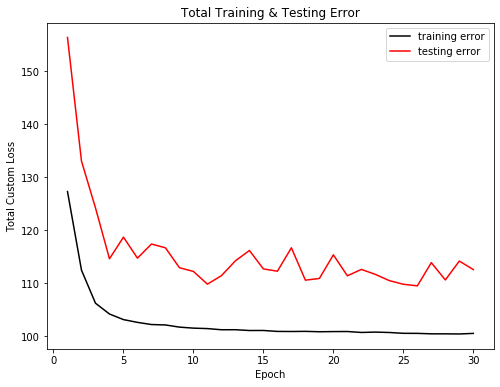

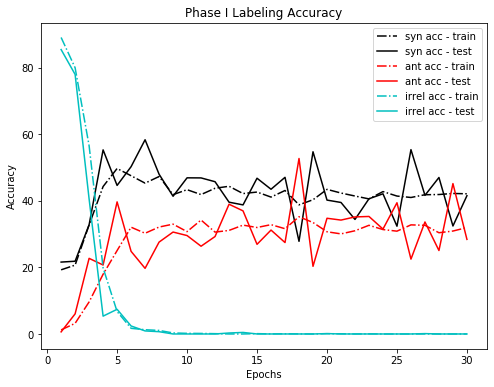

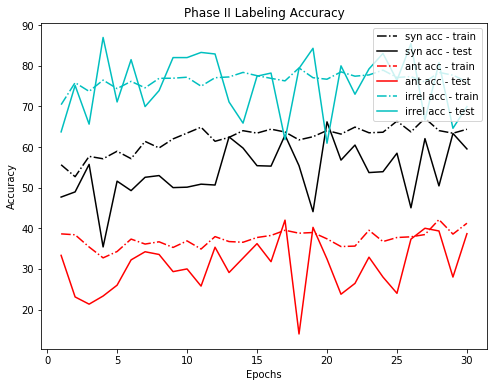

In [12]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Custom Loss')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, syn_train_epoch_accuracies, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, syn_test_epoch_accuracies, c = 'k', label = 'syn acc - test')
plt.plot(epochs, ant_train_epoch_accuracies, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, ant_test_epoch_accuracies, c = 'r', label = 'ant acc - test')
plt.plot(epochs, irrel_train_epoch_accuracies, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, irrel_test_epoch_accuracies, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase I Labeling Accuracy")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(epochs, train_p2_syn_accs, c = 'k', linestyle = '-.', label = 'syn acc - train')
plt.plot(epochs, test_p2_syn_accs, c = 'k', label = 'syn acc - test')
plt.plot(epochs, train_p2_ant_accs, c = 'r', linestyle = '-.', label = 'ant acc - train')
plt.plot(epochs, test_p2_ant_accs, c = 'r', label = 'ant acc - test')
plt.plot(epochs, train_p2_irrel_accs, c = 'c', linestyle = '-.', label = 'irrel acc - train')
plt.plot(epochs, test_p2_irrel_accs, c = 'c', label = 'irrel acc - test')
plt.legend(loc = 'upper right')
plt.title("Phase II Labeling Accuracy")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

In [ ]:
#thresholding the predicted values to be compared to the labels
syn_predictions = list(map(lambda x:1 if x >= 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, syn_predictions))
syn_predictions = list(map(lambda x:-1 if x <= -0.8 else x, syn_predictions))

ant_predictions = list(map(lambda x:1 if x >= 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:0 if -0.8 < x < 0.8 else x, ant_predictions))
ant_predictions = list(map(lambda x:-1 if x <= -0.8 else x, ant_predictions))


#synonymy confusion matrix
syn_matrix = confusion_matrix(syn_true, syn_predictions)

#antonymy confusion matrix
ant_matrix = confusion_matrix(ant_true, ant_predictions)

In [ ]:
syn_matrix

In [ ]:
ant_matrix